In [1]:
import os
import torch
import torchvision.transforms as T

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.image import imread

import numpy as np 

from sklearn.decomposition import PCA

In [2]:
def get_model():
    dinov2_vitb14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
    return dinov2_vitb14


def get_image(path): # returns torch.tesnor
    # get image corresponding to path
    img = imread(path)
    
    if img.shape[-1] != 3:
        return
    # initialize transformations for images
    transform = T.Compose([
        T.ToTensor(),
        T.Resize((224, 224)),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])
    
    # apply transformations to image
    img = transform(img)[:3].unsqueeze(0)

    return img


def get_dataset(cat_img_path, dog_imgs_path, number_of_images_per_class): # returns torch.tensor for images
    images = []                                                           # returns numpy.ndarray for labels
    labels = []
    image_names = [] # Added line
    cat_img_names = os.listdir(cat_img_path)
    np.random.shuffle(cat_img_names)
    
    for name in cat_img_names[:number_of_images_per_class]:
        img_path = os.path.join(cat_img_path, name)
        extension = img_path.split('.')[-1]
        if extension != 'db':
            tmp_img = get_image(img_path)
            if tmp_img is not None:
                images.append(tmp_img)
                labels.append(torch.tensor(0))
                image_names.append(name)  # Added line
    
    dog_img_names = os.listdir(dog_imgs_path)
    np.random.shuffle(dog_img_names)
    for name in dog_img_names[:number_of_images_per_class]:
        img_path = os.path.join(dog_imgs_path, name)
        extension = img_path.split('.')[-1]
        if extension != 'db':
            tmp_img = get_image(img_path)
            if tmp_img is not None:
                images.append(tmp_img)
                labels.append(torch.tensor(1))
                image_names.append(name)  # Added line
    
    images = torch.cat(images, dim=0)
    labels = np.array(labels)
    
    return images, labels, image_names 


def get_image_features(model, images): # returns numpy.ndarray
    model.eval()
    features = []
    for img in tqdm(images):
        with torch.no_grad():
            x = model.prepare_tokens_with_masks(img.unsqueeze(0))
            for i, blk in enumerate(model.blocks):
                x = blk(x)
            x = model.norm(x)
            
            img_features = x[:, 0, :]
            features.append(img_features)
    features = torch.cat(features, dim=0)
    print()
    return features.detach().numpy()


def get_patch_features(model, images): # returns numpy.ndarray
    model.eval()
    features = []
    for img in tqdm(images):
        with torch.no_grad():
            x = model.prepare_tokens_with_masks(img)
            for i, blk in enumerate(model.blocks):
                x = blk(x)
            x = model.norm(x)
            
            patch_features = x[:, 1:, :]
            features.append(img_features)
    features = torch.cat(features, dim=0)
    return features.detach().numpy()

In [4]:
images, labels, image_names = get_dataset(r"C:\Users\davoy\Downloads\FinalProject\FinalProject\images\Cat", r"C:\Users\davoy\Downloads\FinalProject\FinalProject\images\Dog", 1000)
model = get_model()

Using cache found in C:\Users\davoy/.cache\torch\hub\facebookresearch_dinov2_main


In [5]:
img_features = get_image_features(model, images)

  0%|          | 0/1994 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


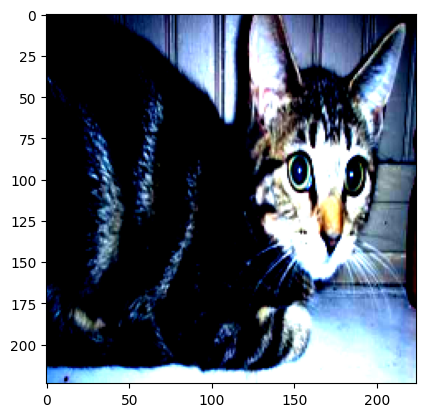

In [9]:
plt.imshow(images[64].permute(1, 2, 0))


In [ ]:
#1

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

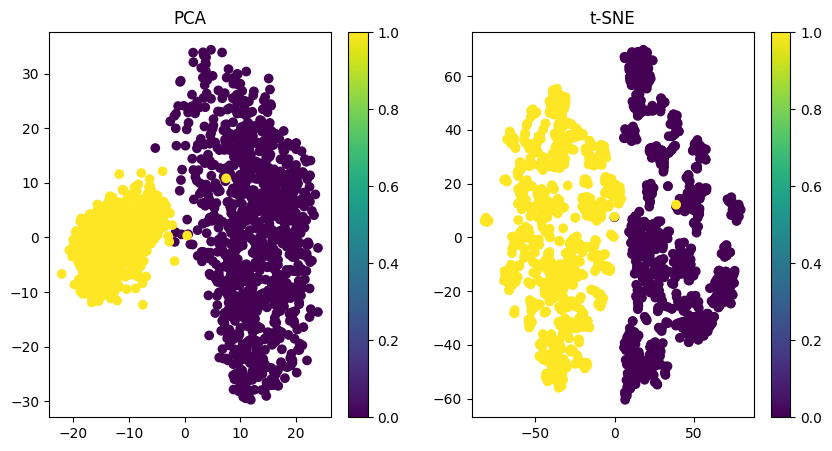

In [13]:

# Perform PCA dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(img_features[:len(images)])

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, perplexity=10)
tsne_result = tsne.fit_transform(img_features[:len(images)])

# Plot PCA results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels[:len(images)])
plt.title('PCA')
plt.colorbar()

# Plot t-SNE results
plt.subplot(1, 2, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels[:len(images)])
plt.title('t-SNE')
plt.colorbar()


In [ ]:
#2

In [16]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(img_features, labels, test_size=0.2, random_state=42)

# Set up KNN model
k = 5  # number of neighbors
model = KNeighborsClassifier(n_neighbors=k)

# Set up cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(model, X_train, y_train, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores for k-NN:", scores)
print("Mean score for k-NN:", scores.mean())



Cross-validation scores for k-NN: [0.99373041 1.         1.         1.         1.        ]
Mean score for k-NN: 0.9987460815047022


In [17]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_predictions = knn.predict(X_test)
knn_test_accuracy = accuracy_score(y_test, knn_predictions)

print("k-NN Accuracy (Test Set):", knn_test_accuracy)

k-NN Accuracy (Test Set): 0.9974937343358395


In [18]:
# Set up your Logistic Regression model with regularization
model = LogisticRegressionCV(cv=5, random_state=42)

# Set up cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(model, X_train, y_train, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores for Logistic Regression:", scores)
print("Mean score for Logistic Regression:", scores.mean())

Cross-validation scores for Logistic Regression: [0.99373041 1.         1.         1.         1.        ]
Mean score for Logistic Regression: 0.9987460815047022


In [19]:
logreg = LogisticRegression(C=1.0, penalty='l2')
logreg.fit(X_train, y_train)
logreg_predictions = logreg.predict(X_test)
logreg_test_accuracy = accuracy_score(y_test, logreg_predictions)

print("Logistic Regression Accuracy (Test Set):", logreg_test_accuracy)

Logistic Regression Accuracy (Test Set): 1.0


In [20]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Set up your SVM model with RBF kernel
model = SVC(kernel='linear')

# Set up regularization parameter values to try
param_grid = {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10]}

# Set up grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5)

# Perform grid search with cross-validation
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best parameters for SVM linear kernel:", grid_search.best_params_)

# Print the best cross-validation score
print("Best cross-validation score for SVM linear kernel:", grid_search.best_score_)
print()

Best parameters for SVM linear kernel: {'C': 0.1, 'gamma': 0.1}
Best cross-validation score for SVM linear kernel: 0.9987460815047022



In [21]:
svm = SVC(kernel='linear', C=0.1, gamma=0.1)
svm.fit(X_train, y_train)
svm_predictions = svm.predict(X_test)
svm_test_accuracy = accuracy_score(y_test, svm_predictions)

print("SVM Accuracy (Test Set):", svm_test_accuracy)

SVM Accuracy (Test Set): 1.0


In [ ]:
#3

auc_lr:  1.0
auc_svm:  1.0


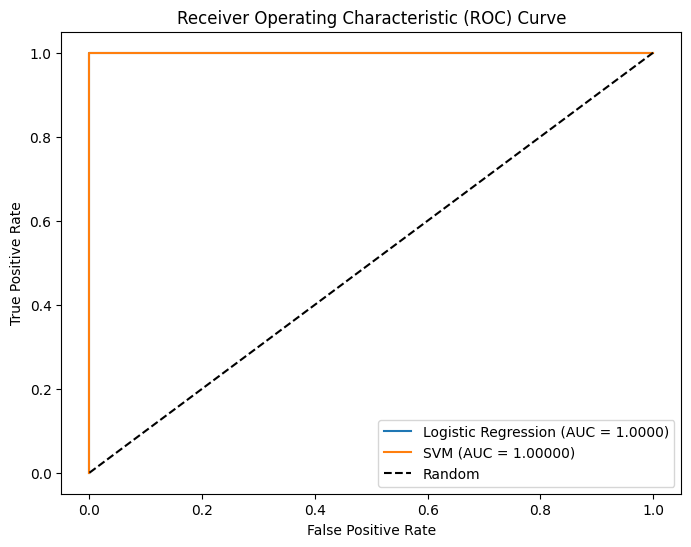

k-NN Accuracy: 0.9974937343358395
k-NN F1 Score: 0.9975669099756691
Logistic Regression Accuracy: 1.0
Logistic Regression F1 Score: 1.0
SVM Accuracy: 1.0
SVM F1 Score: 1.0


In [24]:
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

# evaluate k-NN
knn_predictions = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)
knn_f1_score = f1_score(y_test, knn_predictions)

# evaluate Logistic Regression
logreg_predictions = logreg.predict(X_test)
logreg_accuracy = accuracy_score(y_test, logreg_predictions)
logreg_f1_score = f1_score(y_test, logreg_predictions)
logreg_probabilities = logreg.predict_proba(X_test)[:, 1]

# evaluate SVM
svm_predictions = svm.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_f1_score = f1_score(y_test, svm_predictions)
svm_probabilities = svm.predict_proba(X_test)[:, 1]

# Calculate and plot ROC curve for LR
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, logreg_probabilities)
auc_lr = auc(fpr_lr, tpr_lr)
print('auc_lr: ', auc_lr)

# Calculate and plot ROC curve for SVM
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, svm_probabilities)
auc_svm = auc(fpr_svm, tpr_svm)
print('auc_svm: ', auc_svm)


# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (AUC = {:.4f})'.format(auc_lr))
plt.plot(fpr_svm, tpr_svm, label='SVM (AUC = {:.5f})'.format(auc_svm))
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print the evaluation metrics
print("k-NN Accuracy:", knn_accuracy)
print("k-NN F1 Score:", knn_f1_score)
print("Logistic Regression Accuracy:", logreg_accuracy)
print("Logistic Regression F1 Score:", logreg_f1_score)
print("SVM Accuracy:", svm_accuracy)
print("SVM F1 Score:", svm_f1_score)

In [6]:
#4

In [25]:
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
dinov2_vitl14

Using cache found in C:\Users\davoy/.cache\torch\hub\facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )


In [26]:
import requests
from PIL import Image
from torchvision import transforms
transform = transforms.Compose([           
                                transforms.Resize(256),                    
                                transforms.CenterCrop(224),               
                                transforms.ToTensor(),                    
                                transforms.Normalize(                      
                                mean=[0.485, 0.456, 0.406],                
                                std=[0.229, 0.224, 0.225]              
                                )])


transform1 = transforms.Compose([           
                                transforms.Resize(520),
                                transforms.CenterCrop(518), #should be multiple of model patch_size                 
                                transforms.ToTensor(),                    
                                transforms.Normalize(mean=0.5, std=0.2)
                                ])

In [27]:

patch_size = dinov2_vitl14.patch_size # patchsize=14

#520//14
patch_h  = 520//patch_size
patch_w  = 520//patch_size

# feat_dim = 384 # vits14
# feat_dim = 768 # vitb14
feat_dim = 1024 # vitl14
# feat_dim = 1536 # vitg14

folder_path = r"C:\Users\davoy\Downloads\FinalProject\FinalProject\images\examples"
total_features  = []
with torch.no_grad():
  for img_path in os.listdir(folder_path):
    img_path = os.path.join(folder_path, img_path)
    img = Image.open(img_path).convert('RGB')
    img_t = transform1(img)
    
    features_dict = dinov2_vitl14.forward_features(img_t.unsqueeze(0))
    features = features_dict['x_norm_patchtokens']
    total_features.append(features)

total_features = torch.cat(total_features, dim=0)
total_features.shape

torch.Size([4, 1369, 1024])

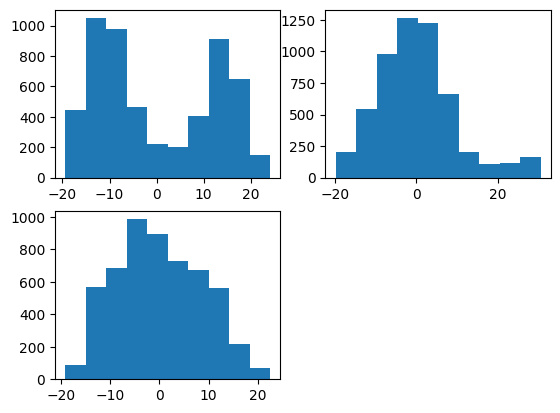

In [28]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# First PCA to Seperate Background
# sklearn expects 2d array for traning
total_features = total_features.reshape(4 * patch_h * patch_w, feat_dim) #4(*H*w, 1024)

pca = PCA(n_components=3)
pca.fit(total_features)
pca_features = pca.transform(total_features)

# visualize PCA components for finding a proper threshold
# 3 histograms for 3 components
plt.subplot(2, 2, 1)
plt.hist(pca_features[:, 0])
plt.subplot(2, 2, 2)
plt.hist(pca_features[:, 1])
plt.subplot(2, 2, 3)
plt.hist(pca_features[:, 2])
plt.show()
plt.close()

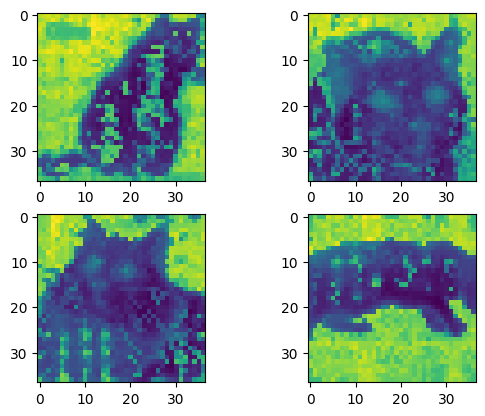

In [29]:
# min_max scale
pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / \
                     (pca_features[:, 0].max() - pca_features[:, 0].min())
#pca_features = sklearn.processing.minmax_scale(pca_features)

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features[i*patch_h*patch_w : (i+1)*patch_h*patch_w, 0].reshape(patch_h, patch_w))

plt.show()

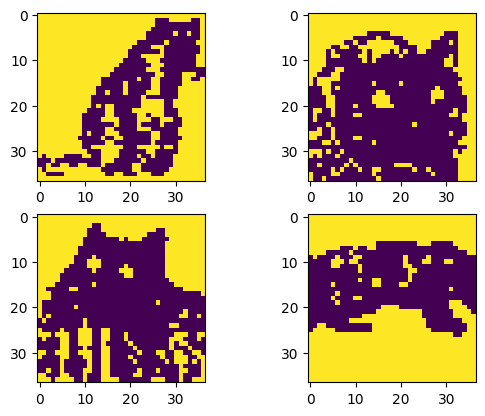

In [30]:
# segment/seperate the backgound and foreground using the first component
pca_features_bg = pca_features[:, 0] > 0.35 # from first histogram
pca_features_fg = ~pca_features_bg

# plot the pca_features_bg
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_bg[i * patch_h * patch_w: (i+1) * patch_h * patch_w].reshape(patch_h, patch_w))
plt.show()


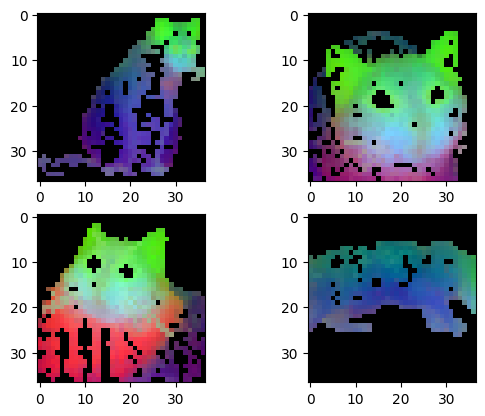

In [31]:
# 2nd PCA for only foreground patches
pca.fit(total_features[pca_features_fg]) 
pca_features_left = pca.transform(total_features[pca_features_fg])

for i in range(3):
    # min_max scaling
    pca_features_left[:, i] = (pca_features_left[:, i] - pca_features_left[:, i].min()) / (pca_features_left[:, i].max() - pca_features_left[:, i].min())

pca_features_rgb = pca_features.copy()
# for black background
pca_features_rgb[pca_features_bg] = 0
# new scaled foreground features
pca_features_rgb[pca_features_fg] = pca_features_left

# reshaping to numpy image format
pca_features_rgb = pca_features_rgb.reshape(4, patch_h, patch_w, 3)
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_rgb[i])

plt.show()

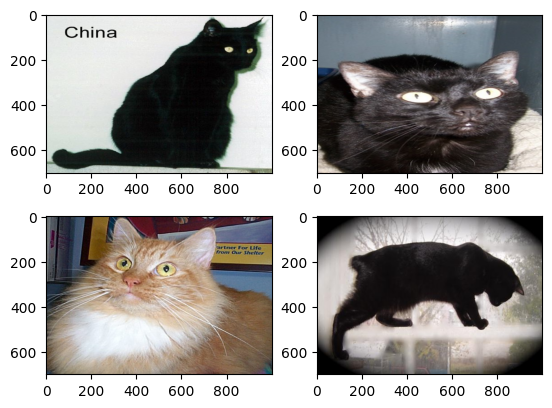

In [32]:
for i,img_path in enumerate(os.listdir(folder_path)):
  img_path = os.path.join(folder_path, img_path)
  img = Image.open(img_path).convert('RGB').resize((1000, 700))
  plt.subplot(2, 2, i+1)
  plt.imshow(img)

plt.show()

Using cache found in C:\Users\davoy/.cache\torch\hub\facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1536, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-39): 40 x NestedTensorBlock(
      (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1536, out_features=4608, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1536, out_features=1536, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (mlp): SwiGLUFFNFused(
        (w12): Linear(in_features=1536, out_features=8192, bias=True)
        (w3): Linear(in_features=4096, out_features=1536, bias=True)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
  (head

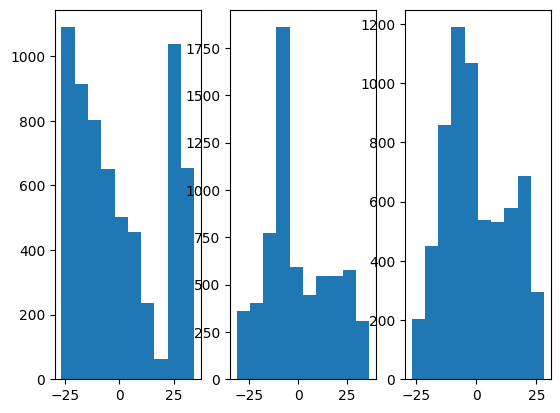

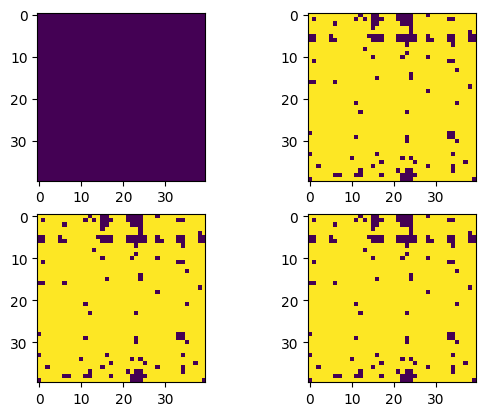

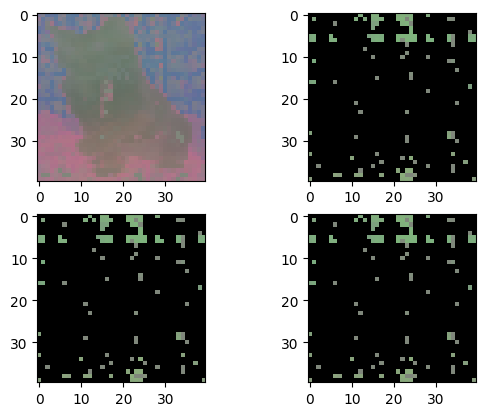

In [53]:
# import torch
# import torch.nn.functional as F
# import torchvision.transforms as T
# import os
# import cv2
# import matplotlib.pyplot as plt
# import numpy as np
# from PIL import Image

# patch_h = 40
# patch_w = 40
# # feat_dim = 384 # vits14
# # feat_dim = 768 # vitb14
# # feat_dim = 1024 # vitl14
# feat_dim = 1536 # vitg14

# transform = T.Compose([
#     T.GaussianBlur(9, sigma=(0.1, 2.0)),
#     T.Resize((patch_h * 14, patch_w * 14)),
#     T.CenterCrop((patch_h * 14, patch_w * 14)),
#     T.ToTensor(),
#     T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
# ])

# # dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
# # dinov2_vitb14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
# # dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
# dinov2_vitg14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')

# print(dinov2_vitg14)

# # extract features
# features = torch.zeros(4, patch_h * patch_w, feat_dim)
# imgs_tensor = torch.zeros(4, 3, patch_h * 14, patch_w * 14)

# img_path = r'C:\Users\davoy\Downloads\FinalProject\FinalProject\images\Cat\11026.jpg'
# img = Image.open(img_path).convert('RGB')
# imgs_tensor[0] = transform(img)[:3]

# with torch.no_grad():
#     features_dict = dinov2_vitg14.forward_features(imgs_tensor)
#     features = features_dict['x_norm_patchtokens']

# # PCA for feature inferred
# from sklearn.decomposition import PCA

# features = features.reshape(4 * patch_h * patch_w, feat_dim)

# pca = PCA(n_components=3)
# pca.fit(features)
# pca_features = pca.transform(features)

# # visualize PCA components for finding a proper threshold
# plt.subplot(1, 3, 1)
# plt.hist(pca_features[:, 0])
# plt.subplot(1, 3, 2)
# plt.hist(pca_features[:, 1])
# plt.subplot(1, 3, 3)
# plt.hist(pca_features[:, 2])
# plt.show()
# plt.close()

# # uncomment below to plot the first pca component
# # pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / (pca_features[:, 0].max() - pca_features[:, 0].min())
# # for i in range(4):
# #     plt.subplot(2, 2, i+1)
# #     plt.imshow(pca_features[i * patch_h * patch_w: (i+1) * patch_h * patch_w, 0].reshape(patch_h, patch_w))
# # plt.show()
# # plt.close()

# # segment using the first component
# pca_features_bg = pca_features[:, 0] < 10
# pca_features_fg = ~pca_features_bg

# # plot the pca_features_bg
# for i in range(4):
#     plt.subplot(2, 2, i+1)
#     plt.imshow(pca_features_bg[i * patch_h * patch_w: (i+1) * patch_h * patch_w].reshape(patch_h, patch_w))
# plt.show()

# # PCA for only foreground patches
# pca.fit(features[pca_features_fg]) # NOTE: I forgot to add it in my original answer
# pca_features_rem = pca.transform(features[pca_features_fg])
# for i in range(3):
#     # pca_features_rem[:, i] = (pca_features_rem[:, i] - pca_features_rem[:, i].min()) / (pca_features_rem[:, i].max() - pca_features_rem[:, i].min())
#     # transform using mean and std, I personally found this transformation gives a better visualization
#     pca_features_rem[:, i] = (pca_features_rem[:, i] - pca_features_rem[:, i].mean()) / (pca_features_rem[:, i].std() ** 2) + 0.5

# pca_features_rgb = pca_features.copy()
# pca_features_rgb[pca_features_bg] = 0
# pca_features_rgb[pca_features_fg] = pca_features_rem

# pca_features_rgb = pca_features_rgb.reshape(4, patch_h, patch_w, 3)
# for i in range(4):
#     plt.subplot(2, 2, i+1)
#     plt.imshow(pca_features_rgb[i][..., ::-1])
# plt.savefig('features.png')
# plt.show()
# plt.close()